## Name: Phuong Do
# Kinetics and Inhibition of Beta-Galactosidase
#### In this project, my objective is to study the effects of three different potential inhibitors of Beta-galactosidase, including IPTG, L-arabinose, and Theophylline by analyzing their kinetic parameters extracted from both Michaelis-Menten and Lineweaver-Burk plots. Primary tasks include:
#### 1. Calculating absorbance rates from raw data and assigning nametags
#### 2. Constructing Lineweaver-Burk and Michaelis-Menten data sets
#### 3. Extracting Vmax and Km for each inhibitor 
#### 4. Classifying inhibition types
#### 5. Generating graphs/tables for comparisons a.
### Experimental procedures and data collection in the project are a part of lab session in CHEM 342 - Structures and Functions of Biomolecules with Lab (Department of Chemistry - Dickinson College)

## I. Function Definitions

In [52]:
# Import necessary libraries, modules, and function
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.optimize import curve_fit

In [54]:
def classifyInhibitor(inhibitor, Vmax, Km, Vmax_app, Km_app, relative_tolerance=0.3):
    """Classifies the type of enzyme 'inhibitor' into Uncompetitive, Competitive, or Noncompetitive inhibitor based on given kinetic parameters.
        - inhibitor (str): name of the inhibitor.
        - Vmax (float):  maximum reaction velocity without the inhibitor.
        - Km (float): Michaelis constant (substrate concentration at half-maximal velocity) without the inhibitor.
        - Vmax_app (float): apparent maximum reaction velocity with the 'inhibitor'.
        - Km_app (float): apparent Michaelis constant with the inhibitor.
        - relative_tolerance (float, optional): Tolerance to determine if two values are close to an extent (default is 0.3)."""
    if Vmax_app < Vmax and Km_app < Km:
        return 'Uncompetitive Inhibitor'
    elif Km_app > Km and math.isclose(Vmax_app, Vmax, rel_tol=relative_tolerance):
        return 'Competitive Inhibitor'
    elif Vmax_app < Vmax:
        return 'Noncompetitive Inhibitor'
    else:
        return 'Unidentified'
        
def michaelisMenten(S, Vmax, Km):
    """Return Michaelis-Menten equation, in which v = (Vmax * S) / (Km + S)"""
    return (Vmax * S) / (Km + S)

def michaelisMentenRegression(dataLabel, dataColor, subConcentration, *trialData):
    """Performs a Michaelis-Menten regression analysis on given reaction rates data.
    This function calculates the average reaction rate from multiple input trials, fits the Michaelis-Menten model to the averaged data, 
    and plots the individual data points along with the fitted curve.
        - dataLabel (str): label for the plotted data series, used in the legend of the plot
        - dataColor (str): color for the fitted curve and data points
        - subConcentration (list): sequence of substrate concentrations used in the enzyme assays 
        - *trialData (lists): one or more trials of reaction rates corresponding to give substrate concentration.
    Returns: tuple, containing Vmax (float) and Km (float)"""
    aveRate = np.mean(np.array(trialData), axis=0)
    popt, _ = curve_fit(michaelisMenten, subConcentration, aveRate, bounds=(0, [3.0, 3.0]))
    Vmax, Km = popt
    xdata = np.linspace(0, max(subConcentration), 100)
    for i, ydata in enumerate(trialData):
        plt.scatter(subConcentration, ydata, alpha=0.6, color=dataColor)
    plt.plot(xdata, michaelisMenten(xdata, *popt), linestyle='--', color=dataColor, label=dataLabel)
    return Vmax, Km

## II. Data Initialization

In [57]:
# Load and read data file
bGfile = "EDUNbgalkinetics2024.xlsx"
bGdata = pd.read_excel(bGfile)

# Define known experimental data and constant
molarAbstvty = 4500 * 1e-3 # molar absorptivity of ONP (4500 mol/ml.cm)
runTime = [0.12, 0.97, 1.82, 2.67, 3.52, 4.37, 5.22, 6.07, 6.92] # Absorbance data recorded at these reaction times (minutes)
substrateConc = [0.078125, 0.15625, 0.3125, 0.625, 1.25, 2.5, 5] # Concentrations of the substrate ONPG (mM)

## III. Data Processing: Absorbance Rates and Substrate Concentrations

In [60]:
# Initialize lists and dictionaries to store results from later analysis 
absorbanceRates = [] # list to store calculated absorbance rate for each well
nameTags = [] # list to store generated nametags for well's identification
absRates = {} # dictionary to store absorbance rate with its right nametag
trioAbsRates = {} # dictionary to store the average of absorbance rates of every three same trials with its right nametag
recipAbsRates = {} # dictionary to store the reciprocal of the average absorbance rate

# Calculate absorbance rates for all wells 
for cols in bGdata.columns:
    slope, intercept = np.polyfit(runTime, bGdata[cols], 1)
    absorbanceRates.append(slope/molarAbstvty)

# Create nametag list
for tag in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']:
    for ez in ['Bgl', 'L', 'IPTG', 'Theo']:
        for num in ['1', '2', '3']:
            nameTags.append(f"{tag}{num}{ez}")         

# Assign each well with the right nametag 
for key, value in zip(nameTags, absorbanceRates):
    absRates[key] = value

# Eliminate unimportant data points ([S]=0)
cleanAbsRates = {key: value for key, value in absRates.items() if 'a' not in key}
rates = list(cleanAbsRates.values())
keys = list(cleanAbsRates.keys())

# Calculate average absorbance rate of every three same trials
for i in range(0, len(list(cleanAbsRates.values())), 3):
    avgRate = sum(rates[i:i+3]) / 3
    key = keys[i]
    trioAbsRates[key] = avgRate 
    
# Calculate reciprocal of the average absorbance rate
for key, value in trioAbsRates.items():
    recipAbsRates[key] = round(1 / (value), 2)
    
# list to store the reciprocal of substrate concentration
recipSubsConc = [] 
# Calculate the reciprocal of substrate concentration
for conc in substrateConc:
    oneToConc = 1 / conc
    recipSubsConc.append(round(oneToConc, 2))

## IV. Lineweaver-Burk Analysis


### a. Equation

The Lineweaver-Burk plot is a double reciprocal plot used in enzyme kinetics to determine $ V_{max} $ and $ K_m $. It is represented by the equation:

$$
\frac{1}{V} = \frac{K_m}{V_{max}} \cdot \frac{1}{[S]} + \frac{1}{V_{max}}
$$

Where:
- V is the initial velocity of the enzyme-catalyzd reaction,
- $ [S] $ is the substrate cncentration,
- $ V_{max} $ is the maxirateion velocity,
- $ K_m $is the Michelis constant.

#### To calculate $ V_{max} $ and $ {K_m} $
The slope of the Lineweaver-Burk plot can be obtained by plotting $ \frac{1}{V} $ vs. $ \frac{1}{[S]} $ to generate
$$
\text{slope} = \frac{K_m}{V_{max}}
$$
$$
\text{y-intercept}  \frac{1}{V_{max}}
$$



### b. Data construction

In [65]:
# list to store the categorized recipAbsRates data 
lineBurkData = {'Beta-galactosidase': [], 'L-Arabonise': [], 'IPTG': [], 'Theophylline': []} 

# Build Lineweaver-Burk Data set
for key, value in recipAbsRates.items():
    if 'Bgl' in key:
        lineBurkData['Beta-galactosidase'].append(value)
    elif 'L' in key:
        lineBurkData['L-Arabonise'].append(value)
    elif 'IPTG' in key:
        lineBurkData['IPTG'].append(value)
    elif 'Theo' in key:
        lineBurkData['Theophylline'].append(value)

lineBurkDf = pd.DataFrame(lineBurkData)

lineBurkDf.insert(0, '1/[S]', recipSubsConc)

In [67]:
# Calculate slope and y-intercept from data
sBeta, incBeta = np.polyfit(lineBurkDf['1/[S]'], lineBurkDf['Beta-galactosidase'], 1)
sL, incL = np.polyfit(lineBurkDf['1/[S]'], lineBurkDf['L-Arabonise'], 1)
sIPTG, incIPTG = np.polyfit(lineBurkDf['1/[S]'], lineBurkDf['IPTG'], 1)
sTheo, incTheo = np.polyfit(lineBurkDf['1/[S]'], lineBurkDf['Theophylline'], 1)

### c. Data Summary and Visualization

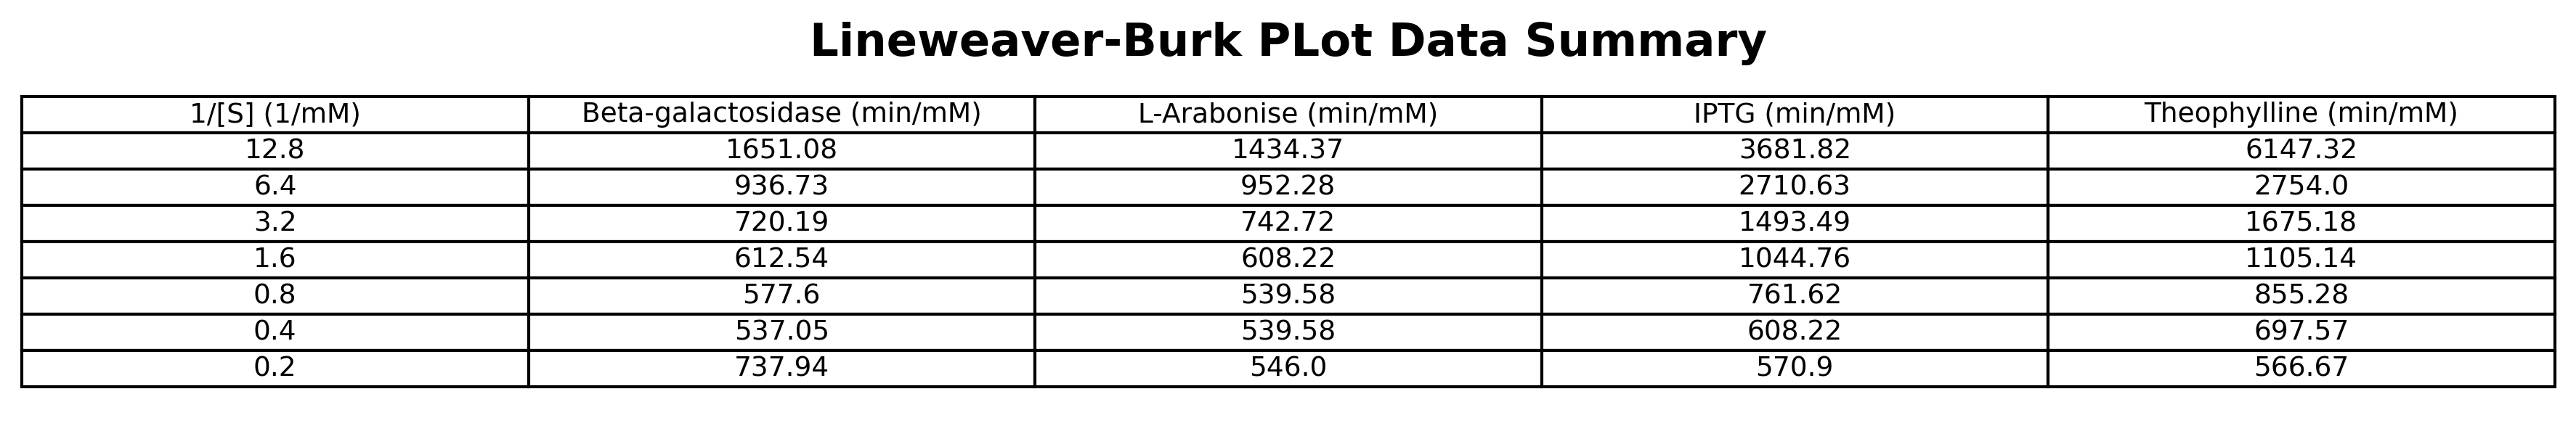

In [70]:
# Display Lineweaver-Burk data summary table
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.axis('tight')
ax.axis('off')

dataLabels = ['1/[S] (1/mM)', 'Beta-galactosidase (min/mM)', 'L-Arabonise (min/mM)', 'IPTG (min/mM)', 'Theophylline (min/mM)']

ax.set_title('Lineweaver-Burk PLot Data Summary', fontsize=15, fontweight='bold')  
table = ax.table(cellText=lineBurkDf.values,colLabels=dataLabels, cellLoc='center', loc='center')

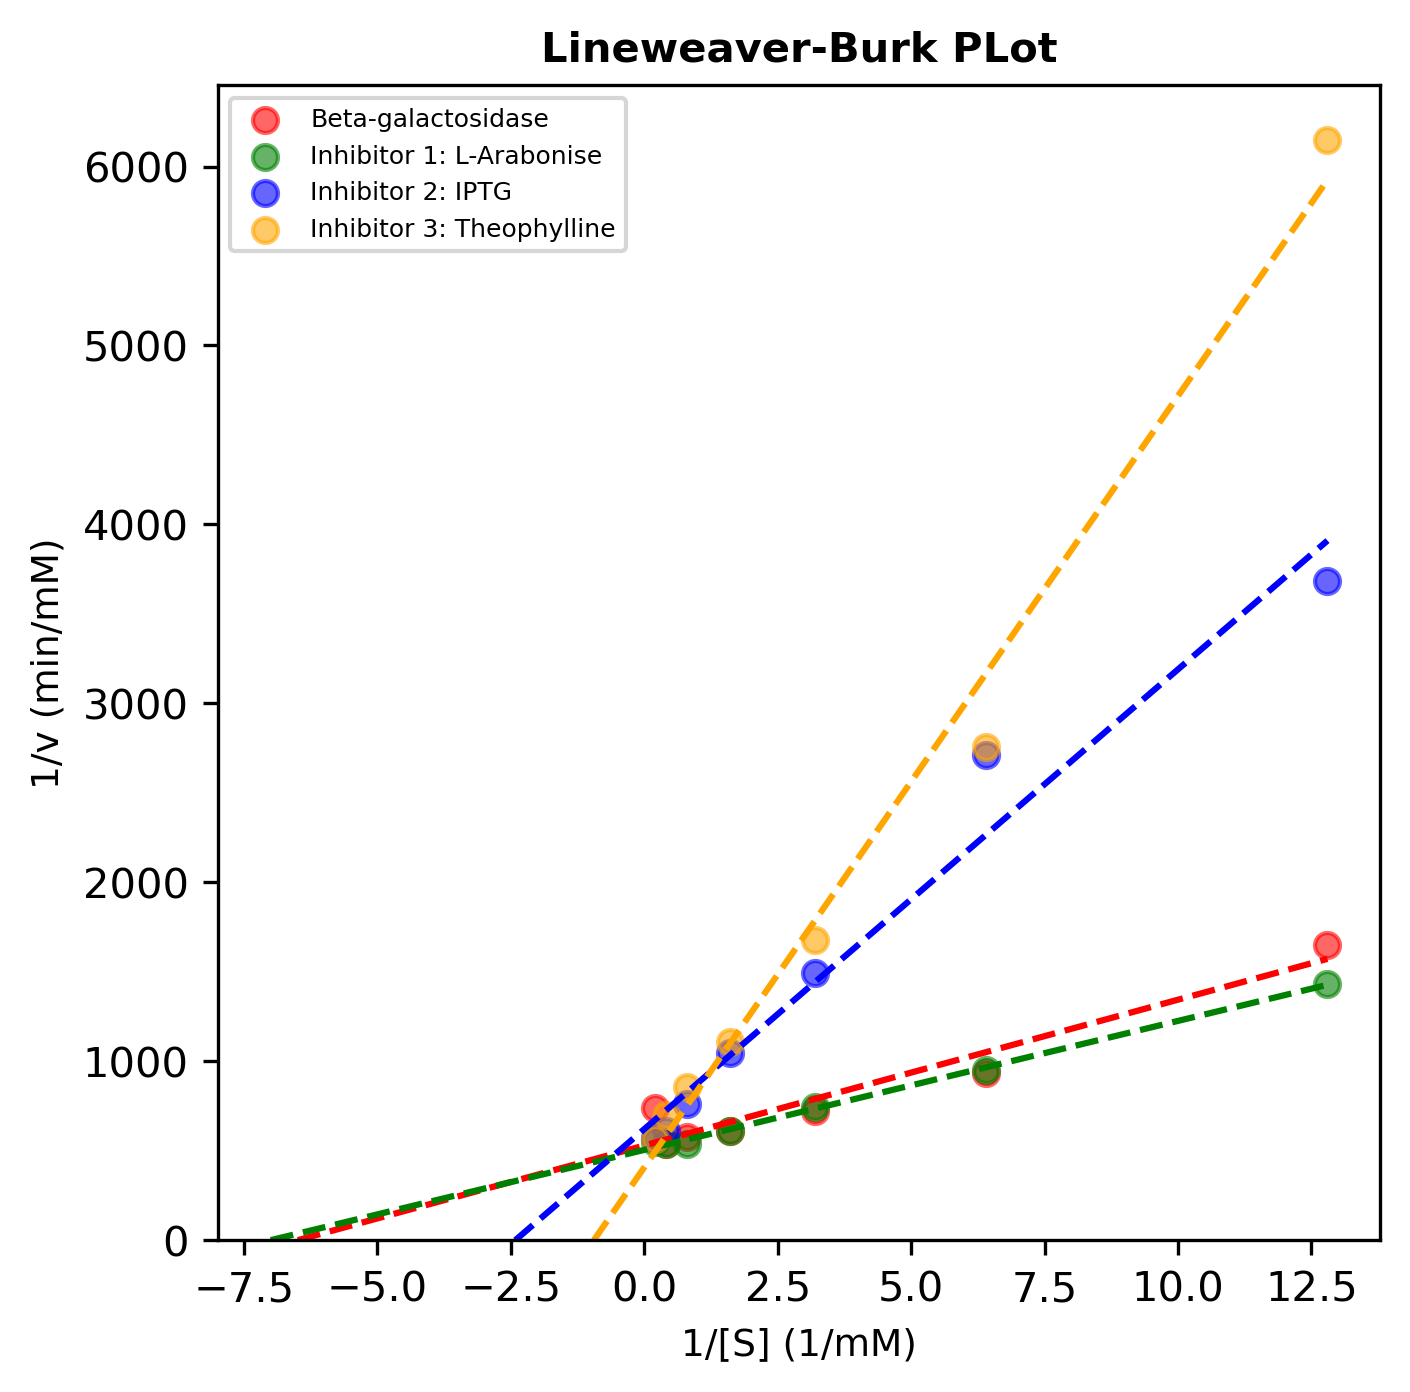

In [72]:
# Plot Lineweaver-Burk scattering points
plt.figure(figsize=(5,5),dpi=300)

plt.scatter(lineBurkDf['1/[S]'], lineBurkDf['Beta-galactosidase'], color='red', label='Beta-galactosidase', alpha=0.6)
plt.scatter(lineBurkDf['1/[S]'], lineBurkDf['L-Arabonise'], color='green', label='Inhibitor 1: L-Arabonise', alpha=0.6)
plt.scatter(lineBurkDf['1/[S]'], lineBurkDf['IPTG'], color='blue', label='Inhibitor 2: IPTG', alpha=0.6)
plt.scatter(lineBurkDf['1/[S]'], lineBurkDf['Theophylline'], color='orange', label='Inhibitor 3: Theophylline', alpha=0.6)

# Plot Lineweaver-Burk fitted lines using the correct slope and intercept values
plt.plot([-inc1/s1, max(lineBurkDf['1/[S]'])], [0, sBeta * max(lineBurkDf['1/[S]']) + incBeta], color='red', linestyle='--')
plt.plot([-inc2/s2, max(lineBurkDf['1/[S]'])], [0, sL * max(lineBurkDf['1/[S]']) + incL], color='green', linestyle='--')
plt.plot([-inc3/s3, max(lineBurkDf['1/[S]'])], [0, sIPTG * max(lineBurkDf['1/[S]']) + incIPTG], color='blue', linestyle='--')
plt.plot([-inc4/s4, max(lineBurkDf['1/[S]'])], [0, sTheo * max(lineBurkDf['1/[S]']) + incTheo], color='orange', linestyle='--')

plt.ylim(bottom=0)
plt.xlabel('1/[S] (1/mM)', fontsize=9)
plt.ylabel('1/v (min/mM)', fontsize=9)
plt.title('Lineweaver-Burk PLot',  fontweight='bold', fontsize=10)
plt.legend(fontsize=6)

plt.show()

### d. Calculations of $V_{\text{max}}$ and $K_{m}$

In [75]:
vMaxBgal = 1 / incBeta
vMaxL = 1 / incL
vMaxIPTG = 1 / incIPTG
vMaxTheo = 1 / incTheo

kMBgal = vMaxBgal * sBeta
kML = vMaxBgal * sL
kMIPTG = vMaxBgal * sIPTG
kMTheo = vMaxBgal * sTheo

### e. Inhibition Classification

In [78]:
cLBL = classifyInhibitor("L-Arabonise", vMaxBgal, kMBgal, vMaxL, kML)
cLBIPTG = classifyInhibitor("IPTG", vMaxBgal, kMBgal, vMaxIPTG, kMIPTG)
cLBTheo = classifyInhibitor("Theophylline", vMaxBgal, kMBgal, vMaxTheo, kMTheo)

## V. Michelis-Menten Analysis

### a. Equation

$$
v = \frac{V_{\max} [S]}{K_m + [S]}$$V_{\max} \).


### b. Data construction

In [83]:
# list to store the categorised absorbance rates data 
michelMenData = {'Beta-galactosidase': [[], [], []],'L-Arabonise': [[], [], []],'IPTG': [[], [], []],'Theophylline': [[], [], []]} 

# Build Michelis-Menten Data set
for key, value in cleanAbsRates.items():
    if 'Bgl' in key:
        if "1" in key:
            michelMenData['Beta-galactosidase'][0].append(value)
        elif "2" in key:
            michelMenData['Beta-galactosidase'][1].append(value)
        elif "3" in key:
            michelMenData['Beta-galactosidase'][2].append(value)
    elif 'L' in key:
        if "1" in key:
            michelMenData['L-Arabonise'][0].append(value)
        elif "2" in key:
            michelMenData['L-Arabonise'][1].append(value)
        elif "3" in key:
            michelMenData['L-Arabonise'][2].append(value)
    elif 'IPTG' in key:
        if "1" in key:
            michelMenData['IPTG'][0].append(value)
        elif "2" in key:
            michelMenData['IPTG'][1].append(value)
        elif "3" in key:
            michelMenData['IPTG'][2].append(value)
    elif 'Theo' in key:
        if "1" in key:
            michelMenData['Theophylline'][0].append(value)
        elif "2" in key:
            michelMenData['Theophylline'][1].append(value)
        elif "3" in key:
            michelMenData['Theophylline'][2].append(value)

### c. Data Visualization

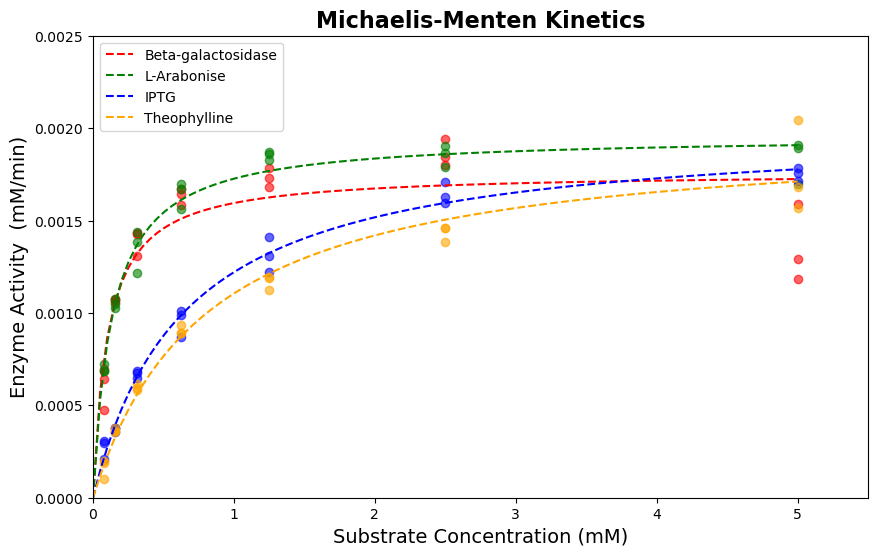

In [112]:
# Plot Michelis-Menten Data
plt.figure(figsize=(10, 6))

mmBeta = michaelisMentenRegression('Beta-galactosidase','red', substrateConc,
                                    michelMenData['Beta-galactosidase'][0],
                                    michelMenData['Beta-galactosidase'][1],
                                    michelMenData['Beta-galactosidase'][2])
mmL = michaelisMentenRegression('L-Arabonise','green', substrateConc,
                                    michelMenData['L-Arabonise'][0],
                                    michelMenData['L-Arabonise'][1],
                                    michelMenData['L-Arabonise'][2])
mmI = michaelisMentenRegression('IPTG','blue', substrateConc,
                                    michelMenData['IPTG'][0],
                                    michelMenData['IPTG'][1],
                                    michelMenData['IPTG'][2])
mmT = michaelisMentenRegression('Theophylline','orange', substrateConc,
                                    michelMenData['Theophylline'][0],
                                    michelMenData['Theophylline'][1],
                                    michelMenData['Theophylline'][2])

plt.xlim(0,5.5)
plt.ylim(0,0.0025)
plt.title('Michaelis-Menten Kinetics', fontsize=16, fontweight='bold')
plt.xlabel('Substrate Concentration (mM)', fontsize=14)
plt.ylabel('Enzyme Activity  (mM/min)', fontsize=14)
plt.legend()

plt.show()


### d. Inhibition Classification

## VI. Summary Tables

In [90]:
cMML = classifyInhibitor("L-Arabonise", mmBeta[0], mmBeta[1], mmL[0], mmL[1])
cMMIPTG = classifyInhibitor("IPTG", mmBeta[0], mmBeta[1], mmI[0], mmI[1])
cMMTheo = classifyInhibitor("Theophylline", mmBeta[0], mmBeta[1], mmT[0], mmT[1])

In [92]:
# Lists to hold Vmax and KM from LB data
vMaxLBList = [vMaxBgal, vMaxL, vMaxIPTG, vMaxTheo]
KMLBList = [kMBgal, kML, kMIPTG, kMTheo]

sumLB = {"Enzyme/Inhibitor": ['Beta-galactosidase',"L-Arabonise","IPTG","Theophylline"],
           "Vmax (mM/min)": [round(num, 5) for num in vMaxLBList],
           "KM(mM)": [round(num, 3) for num in KMLBList],
         "Inhibition type": ["N/A", cLBL, cLBIPTG, cLBTheo]}    

dfLB = pd.DataFrame(sumLB)
print(dfLB)

#fig, ax = plt.subplots(figsize=(5, 1), dpi=300) 
#ax.axis('tight')
#ax.axis('off')
#ax.set_title('Lineweaver-Burk Kinetics and Inhibition', fontweight='bold', fontsize = 8)  
#table = ax.table(cellText=dfMM.values, colLabels=dfMM.columns, cellLoc='center', loc='center')      

     Enzyme/Inhibitor  Vmax (mM/min)  KM(mM)        Inhibition type
0  Beta-galactosidase        0.00189   0.154                    N/A
1         L-Arabonise        0.00198   0.136           Unidentified
2                IPTG        0.00161   0.486  Competitive Inhibitor
3        Theophylline        0.00246   0.815  Competitive Inhibitor


In [114]:
# Lists to hold Vmax and KM from MM data
vMaxMMList = [mmBeta[0], mmL[0], mmI[0], mmT[0]]
KMMMList = [mmBeta[1], mmL[1], mmI[1], mmT[1]]

sumMM = {"Enzyme/Inhibitor": ['Beta-galactosidase',"L-Arabonise","IPTG","Theophylline"],
           "Vmax (mM/min)": [round(num, 5) for num in vMaxMMList],
           "KM(mM)": [round(num, 3) for num in KMMMList],
         "Inhibition type": ["N/A", cMML, cMMIPTG, cMMTheo]}    

dfMM = pd.DataFrame(sumMM)
print(dfMM)

#fig, ax = plt.subplots(figsize=(5, 1), dpi=300) 
#ax.axis('tight')
#ax.axis('off')
#ax.set_title('Michelis-Menten Kinetics and Inhibition', fontweight='bold', fontsize = 8)  
#table = ax.table(cellText=dfMM.values, colLabels=dfMM.columns, cellLoc='center', loc='center')     

     Enzyme/Inhibitor  Vmax (mM/min)  KM(mM)        Inhibition type
0  Beta-galactosidase        0.00176   0.104                    N/A
1         L-Arabonise        0.00196   0.135  Competitive Inhibitor
2                IPTG        0.00201   0.644  Competitive Inhibitor
3        Theophylline        0.00198   0.794  Competitive Inhibitor
